In [1]:

# cd drive/MyDrive/Colab\ Notebooks/


In [2]:
# ls

# Imports + Setup

In [1]:
import os, re
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import joblib
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import random

In [2]:
# Set seeds for reproducibility
import random
SEED = 1
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior for CUDA
torch.backends.cudnn.benchmark = False      # Disable auto-tuner that can introduce randomness

In [4]:
# File Mapping
h_map = {2: 0.0375, 3: 0.084, 6: 0.1575}
flux_map = {88: 25900, 78: 21250, 73: 19400}
abs_map = {0: 3, 92: 100}
surf_map = {0: 0.98, 1: 0.76}
pattern = r"h(\d+)_flux(\d+)_abs(\d+)(?:_[A-Za-z0-9]+)*_surf([01])(?:_[A-Za-z0-9]+)*[\s_]+(\d+)s\b"
# Depending on where u store the data files
# cd drive/MyDrive/Colab\ Notebooks/Theoretical_VTDP
DATA_DIR = "data/all_processed_time_reset"
# DATA_DIR = "../../../data/Theoretical_VTDP"

# DATA_DIR = "Theoretical_VTDP/"
DROP_COLS = ["TC_9_5", "TC_Bottom_rec_groove", "TC_wall_ins_ext", "TC_bottom_ins_groove", "Theoretical_Temps_11"]

# Utilities

In [5]:
def parse_filename_params(filename):
    m = re.search(pattern, filename)
    if not m:
        return None
    h_raw    = int(m.group(1))
    flux_raw = int(m.group(2))
    abs_raw  = int(m.group(3))
    surf_raw = int(m.group(4))
    t        = int(m.group(5))

    # keeping number if no entry exists
    h    = h_map.get(h_raw,    h_raw)
    flux = flux_map.get(flux_raw, flux_raw)
    abs_ = abs_map.get(abs_raw,  abs_raw)
    surf = surf_map.get(surf_raw)

    return h, flux, abs_, surf, t

def load_and_process_file(path, h, flux, abs_val, surf, min_time, filename):
    """Automatically computes cooling rates (C/s) from Time and TC_* columns"""
    df = pd.read_csv(path, encoding="utf-8-sig")
    df = df[df["Time"] >= min_time].copy()
    
    # # Calculate cooling rates for all temperature sensors
    # for col in df.columns:
    #     if col.startswith("TC_"):
    #         df[f"{col}_rate"] = df[col].diff() / df["Time"].diff()  # ΔT/Δt
    
    df.drop(columns=[col for col in df.columns if col in DROP_COLS or col.startswith("Depth_")], inplace=True)
    df["h"] = h
    df["flux"] = flux
    df["abs"] = abs_val
    df["surf"] = surf
    df["filename"] = filename
    
    return df.iloc[1:]



# Load and Combine Data

In [6]:
dataframes = []
for fname in os.listdir(DATA_DIR):
    if not fname.endswith(".csv"):
        continue

    params = parse_filename_params(fname)
    if params is None or params[3] is None:
        print("Skipping (unmatched):", fname)
        continue

    path = os.path.join(DATA_DIR, fname)
    df = load_and_process_file(path, *params, filename=fname)
    dataframes.append(df)
    
data = pd.concat(dataframes, ignore_index=True)
print(data.info())
print(data.head())

Skipping (unmatched): cleaned_h2_flux88_abs25_wr_surfParAdded_169s - Sheet1_processed.csv
Skipping (unmatched): cleaned_h2_flux88_abs25_wr_surfSimD_525s - Sheet1_processed.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25103 entries, 0 to 25102
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Time                  25103 non-null  int64  
 1   TC1_tip               25103 non-null  float64
 2   TC2                   25103 non-null  float64
 3   TC3                   25103 non-null  float64
 4   TC4                   25103 non-null  float64
 5   TC5                   25103 non-null  float64
 6   TC6                   25103 non-null  float64
 7   TC7                   25103 non-null  float64
 8   TC8                   25103 non-null  float64
 9   TC9                   25103 non-null  float64
 10  TC10                  25103 non-null  float64
 11  Theoretical_Temps_1   25103 non-null  float64
 

# H6 Only Dataset

In [ ]:
# dataframes = []
# for fname in os.listdir(DATA_DIR):
#     if not fname.endswith(".csv"):
#         continue

#     params = parse_filename_params(fname)
#     if params is None or params[3] is None:
#         print("Skipping (unmatched):", fname)
#         continue

#     h_val = params[0]
#     if h_val != h_map[6]:  # Only include h6 = 0.1575
#         print("Skipping (not h6):", fname)
#         continue

#     path = os.path.join(DATA_DIR, fname)
#     df = load_and_process_file(path, *params,filename=fname)
#     dataframes.append(df)
#     data = pd.concat(dataframes, ignore_index=True)
# print(data.info())
# print(data.head())


Skipping (not h6): h2_flux88_abs0_mr_surf0_571s - Sheet1_processed.csv
Skipping (not h6): h2_flux88_abs0_surf0_431s - Sheet1_processed.csv
Skipping (not h6): h2_flux88_abs0_surf0_585s - Sheet2_processed.csv
Skipping (not h6): h2_flux88_abs0_surf0_probeUp_590s - Sheet2_processed.csv
Skipping (not h6): h2_flux88_abs0_wr_surf0_368s - Sheet1_processed.csv
Skipping (not h6): h2_flux88_abs25_newSalt_surf0_172s - Sheet1_processed.csv
Skipping (not h6): h2_flux88_abs25_newSalt_wr_surf0_123s - Sheet1_processed.csv
Skipping (not h6): h2_flux88_abs25_surf0_493s - Sheet1_processed.csv
Skipping (not h6): h2_flux88_abs25_wr_surf0_393s - Sheet1_processed.csv
Skipping (unmatched): h2_flux88_abs25_wr_surfParAdded_169s - Sheet1_processed.csv
Skipping (unmatched): h2_flux88_abs25_wr_surfSimD_525s - Sheet1_processed.csv
Skipping (not h6): h2_flux88_abs92_surf0_115s - Sheet1_processed.csv
Skipping (not h6): h2_flux88_abs92_surf0_probeUp_193s - Sheet1_processed.csv
Skipping (not h6): h2_flux88_abs92_wr_surf

# Preprocessing

In [ ]:
# if data is not None and not data.empty:
#     print("\nStarting preprocessing...")
    
#     # Identify columns
#     theory_cols = [c for c in data.columns if c.startswith("Theoretical_Temps_")]
#     rate_cols = [c for c in data.columns if c.endswith("_rate")] 
#     tc_cols = [col for col in data.columns if col.startswith("TC") and not col.endswith("_rate")]
    
#     print(f"Found {len(theory_cols)} theoretical temperature columns")
#     print(f"Found {len(rate_cols)} rate columns")
#     print(f"Found {len(tc_cols)} TC sensor columns")
    
#     # Prepare features and targets
#     filenames = data["filename"].reset_index(drop=True)
#     X = data[["Time", "h", "flux", "abs", "surf"] + theory_cols + rate_cols].copy()
#     X["filename"] = filenames
#     y = data[tc_cols].copy()
#     y_columns = y.columns
    
#     print(f"Feature matrix shape: {X.shape}")
#     print(f"Target matrix shape: {y.shape}")
    
#     # Check for missing values
#     print(f"\nMissing values in X: {X.isnull().sum().sum()}")
#     print(f"Missing values in y: {y.isnull().sum().sum()}")
    
#     # Remove rows with missing values if any
#     if X.isnull().sum().sum() > 0 or y.isnull().sum().sum() > 0:
#         print("Removing rows with missing values...")
#         mask = ~(X.isnull().any(axis=1) | y.isnull().any(axis=1))
#         X = X[mask].reset_index(drop=True)
#         y = y[mask].reset_index(drop=True)
#         print(f"After removing missing values - X shape: {X.shape}, y shape: {y.shape}")
    
#     # Train-test split
#     X_train_raw, X_temp_raw, y_train_raw, y_temp_raw = train_test_split(
#         X.drop(columns="filename"), y, test_size=0.3, random_state=SEED
#     )
#     X_val_raw, X_test_raw, y_val_raw, y_test_raw = train_test_split(
#         X_temp_raw, y_temp_raw, test_size=0.5, random_state=SEED
#     )

#     train_filenames = X.loc[X_train_raw.index, "filename"].unique().tolist()
#     val_filenames = X.loc[X_val_raw.index, "filename"].unique().tolist()
#     test_filenames = X.loc[X_test_raw.index, "filename"].unique().tolist()

#     print(f"\nTrain set: {X_train_raw.shape[0]} samples")
#     print(f"Validation set: {X_val_raw.shape[0]} samples")
#     print(f"Test set: {X_test_raw.shape[0]} samples")
#     print("Train Files:", train_filenames)
#     print("Val Files:", val_filenames)
#     print("Test Files:", test_filenames)

#     # Check if we have valid data for scaling
#     if X_train_raw.empty or y_train_raw.empty:
#         print("ERROR: Training data is empty!")
#     else:
#         print("\nScaling data...")
#         # Scaling
#         X_scaler = MinMaxScaler()
#         X_train_scaled = X_scaler.fit_transform(X_train_raw)
#         X_val_scaled = X_scaler.transform(X_val_raw)
#         X_test_scaled = X_scaler.transform(X_test_raw)

#         y_scaler = MinMaxScaler()
#         y_train_scaled = y_scaler.fit_transform(y_train_raw)
#         y_val_scaled = y_scaler.transform(y_val_raw)
#         y_test_scaled = y_scaler.transform(y_test_raw)

#         # Save scalers
#         joblib.dump(X_scaler, "X_scaler.pkl")
#         joblib.dump(y_scaler, "y_scaler.pkl")
#         print("Scalers saved successfully")

#         # Convert to tensors and create DataLoader
#         train_dataset = TensorDataset(
#             torch.tensor(X_train_scaled, dtype=torch.float32), 
#             torch.tensor(y_train_scaled, dtype=torch.float32)
#         )
#         val_dataset = TensorDataset(
#             torch.tensor(X_val_scaled, dtype=torch.float32), 
#             torch.tensor(y_val_scaled, dtype=torch.float32)
#         )
#         test_dataset = TensorDataset(
#             torch.tensor(X_test_scaled, dtype=torch.float32), 
#             torch.tensor(y_test_scaled, dtype=torch.float32)
#         )

#         train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
#         val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
#         test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
        
#         print("Data preprocessing completed successfully!")
#         print(f"Ready for training with input size: {X_train_scaled.shape[1]}")
#         print(f"Output size: {y_train_scaled.shape[1]}")
        
# else:
#     print("ERROR: Cannot proceed with preprocessing - no data was loaded!")
#     print("Please check your data directory and file structure.")


Starting preprocessing...
Found 10 theoretical temperature columns
Found 4 rate columns
Found 10 TC sensor columns
Feature matrix shape: (66069, 20)
Target matrix shape: (66069, 10)

Missing values in X: 209647
Missing values in y: 0
Removing rows with missing values...
After removing missing values - X shape: (11112, 20), y shape: (11112, 10)

Train set: 7778 samples
Validation set: 1667 samples
Test set: 1667 samples
Train Files: ['h3_flux88_abs25_wr_surf0_746s-Sheet2_processed.csv', 'h3_flux88_abs0_wr_surf0_416s-Sheet1_processed.csv', 'h3_flux88_abs25_wr_surf0_422s-Sheet1_processed.csv', 'h3_flux88_abs0_mr_surf0_635s-Sheet1_processed.csv', 'h3_flux88_abs90_surf0_Redone_again2_398s-Sheet1_processed.csv', 'h3_flux88_abs0_surf0_719s-Sheet1_processed.csv', 'h3_flux88_abs25_surf0_439s-Sheet2_processed.csv', 'h3_flux88_abs0_surf0_825s-Sheer3_processed.csv', 'h3_flux88_abs90_surf0_Redone_again3_344s-Sheet1_processed.csv', 'h3_flux88_abs90_surf0_Redone_again_266s-Sheet1_processed.csv', 'h3

In [7]:
if data is not None:
    theory_cols = [c for c in data.columns if c.startswith("Theoretical_Temps_")]
    # rate_cols = [c for c in data.columns if c.endswith("_rate")] 
    filenames = data["filename"].reset_index(drop=True)

    # X = data[["Time", "h", "flux", "abs", "surf"] + theory_cols + rate_cols].copy()
    X = data[["Time", "h", "flux", "abs", "surf"] + theory_cols].copy()

    X["filename"] = filenames
    y = data.drop(columns=["Time", "h", "flux", "abs", "surf"] + theory_cols + ["filename"], errors='ignore')
    # y = data[[col for col in data.columns if col.startswith("TC") and not col.endswith("_rate")]].copy()
    y_columns = y.columns

    X_train_raw, X_temp_raw, y_train_raw, y_temp_raw = train_test_split(
        X.drop(columns="filename"), y, test_size=0.3, random_state=SEED
    )
    X_val_raw, X_test_raw, y_val_raw, y_test_raw = train_test_split(
        X_temp_raw, y_temp_raw, test_size=0.5, random_state=SEED
    )

    train_filenames = X.loc[X_train_raw.index, "filename"].unique().tolist()
    val_filenames = X.loc[X_val_raw.index, "filename"].unique().tolist()
    test_filenames = X.loc[X_test_raw.index, "filename"].unique().tolist()

    print("Train Files:", train_filenames)
    print("Val Files:", val_filenames)
    print("Test Files:", test_filenames)

    # Scaling
    X_scaler = MinMaxScaler()
    X_train_scaled = X_scaler.fit_transform(X_train_raw)
    X_val_scaled = X_scaler.transform(X_val_raw)
    X_test_scaled = X_scaler.transform(X_test_raw)

    y_scaler = MinMaxScaler()
    y_train_scaled = y_scaler.fit_transform(y_train_raw)
    y_val_scaled = y_scaler.transform(y_val_raw)
    y_test_scaled = y_scaler.transform(y_test_raw)

    joblib.dump(X_scaler, "X_scaler.pkl")
    joblib.dump(y_scaler, "y_scaler.pkl")

    # Convert to tensors and create DataLoader
    train_dataset = TensorDataset(torch.tensor(X_train_scaled, dtype=torch.float32), torch.tensor(y_train_scaled, dtype=torch.float32))
    val_dataset = TensorDataset(torch.tensor(X_val_scaled, dtype=torch.float32), torch.tensor(y_val_scaled, dtype=torch.float32))
    test_dataset = TensorDataset(torch.tensor(X_test_scaled, dtype=torch.float32), torch.tensor(y_test_scaled, dtype=torch.float32))

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Train Files: ['cleaned_h6_flux88_abs20_surf0_longRun_780s - Sheet1_processed.csv', 'cleaned_h6_flux88_abs0_surf1_545s - Sheet2_processed.csv', 'cleaned_h3_flux88_abs90_surf0_Redone_again2_398s-Sheet1_processed.csv', 'cleaned_h6_flux73_abs0_surf0_newSalt_398s - Sheet1_processed.csv', 'cleaned_h6_flux88_abs20_surf0_longRun_612s - Sheet2_processed.csv', 'cleaned_h6_flux78_abs0_surf1_newSalt_505s - Sheet3_processed.csv', 'cleaned_h6_flux88_abs0_surf0_longRun_762s - Sheet1_processed.csv', 'cleaned_h6_flux78_abs0_surf0_523s - Sheet2_processed.csv', 'cleaned_h2_flux88_abs25_newSalt_wr_surf0_123s - Sheet1_processed.csv', 'cleaned_h2_flux88_abs92_surf0_probeUp_193s - Sheet1_processed.csv', 'cleaned_h2_flux88_abs25_wr_surf0_393s - Sheet1_processed.csv', 'cleaned_h6_flux78_abs0_surf0_newSalt_641s - Sheet1_processed.csv', 'cleaned_h6_flux78_abs0_surf0_450s - Sheet3_processed.csv', 'cleaned_h2_flux88_abs92_surf0_115s - Sheet1_processed.csv', 'cleaned_h6_flux73_abs0_surf0_429s - Sheet2_processed.csv

# Model

In [8]:
# Model with SiLU and Corrected Residual Connection
class EnhancedThermalNet(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.input_layer = nn.Linear(input_size, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.silu = nn.SiLU()
        self.dropout = nn.Dropout(0.3)

        self.layer1 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.layer2 = nn.Linear(256, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.layer3 = nn.Linear(256, 128)
        self.bn4 = nn.BatchNorm1d(128)
        self.output_layer = nn.Linear(128, output_size)

        # Projection layer for residual connection
        self.residual_proj = nn.Linear(512, 256)

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.silu(self.bn1(self.input_layer(x)))
        residual = self.residual_proj(x)
        x = self.dropout(x)
        
        x = self.silu(self.bn2(self.layer1(x)))
        x = self.silu(self.bn3(self.layer2(x)))
        x = x + residual
        x = self.dropout(x)
        
        x = self.silu(self.bn4(self.layer3(x)))
        return self.output_layer(x)


# Training

In [9]:
# Training Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = X_train_scaled.shape[1]
output_size = y_train_scaled.shape[1]
model = EnhancedThermalNet(
    input_size=X_train_scaled.shape[1],  # Automatically includes cooling rates
    output_size=y_train_scaled.shape[1]
                           ).to(device)

optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

class EnhancedLoss(nn.Module):
    def __init__(self, smoothness_lambda=0.001):
        super().__init__()
        self.mse_loss = nn.MSELoss()
        self.smoothness_lambda = smoothness_lambda

    def forward(self, preds, targets):
        mse = self.mse_loss(preds, targets)
        smoothness = torch.mean(torch.abs(preds[:, 1:] - preds[:, :-1]))
        return mse + self.smoothness_lambda * smoothness

criterion = EnhancedLoss()
# Training Loop
EPOCHS = 1000
best_val_loss = float('inf')
patience = 50
patience_counter = 0
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    model.train()
    train_loss_epoch = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        predictions = model(X_batch)
        train_loss = criterion(predictions, y_batch)
        train_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss_epoch += train_loss.item()
    
    train_loss_epoch /= len(train_loader)
    
    model.eval()
    val_loss_epoch = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            val_preds = model(X_batch)
            val_loss = criterion(val_preds, y_batch)
            val_loss_epoch += val_loss.item()
    
    val_loss_epoch /= len(val_loader)
    scheduler.step()

    train_losses.append(train_loss_epoch)
    val_losses.append(val_loss_epoch)

    if val_loss_epoch < best_val_loss:
        best_val_loss = val_loss_epoch
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_val_loss,
        }, 'best_model_checkpoint.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}] Train Loss: {train_loss_epoch:.6f} Val Loss: {val_loss_epoch:.6f}")

# Load best model
checkpoint = torch.load('best_model_checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])

Epoch [50/1000] Train Loss: 0.003402 Val Loss: 0.003187
Epoch [100/1000] Train Loss: 0.002474 Val Loss: 0.002472
Epoch [150/1000] Train Loss: 0.002671 Val Loss: 0.002806
Early stopping at epoch 174


<All keys matched successfully>

# Evaluation

In [10]:
# Evaluation
def evaluate_model(model, loader, scaler):
    model.eval()
    preds = []
    y_true = []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            pred = model(X_batch).cpu().numpy()
            preds.append(pred)
            y_true.append(y_batch.numpy())
    
    preds = np.concatenate(preds)
    y_true = np.concatenate(y_true)
    preds_real = scaler.inverse_transform(preds)
    y_real = scaler.inverse_transform(y_true)
    rmse = np.sqrt(np.mean((preds_real - y_real) ** 2, axis=0))
    mae = np.mean(np.abs(preds_real - y_real), axis=0)
    y_mean = np.mean(y_real, axis=0)
    ss_tot = np.sum((y_real - y_mean) ** 2, axis=0)
    ss_res = np.sum((y_real - preds_real) ** 2, axis=0)
    r2 = 1 - (ss_res / (ss_tot + 1e-8))
    return preds_real, y_real, rmse, mae, r2

preds_real, y_real, rmse, mae, r2 = evaluate_model(model, test_loader, y_scaler)

print("\n=== Comprehensive Evaluation ===")
print(f"{'Sensor':<15} {'RMSE (°C)':<12} {'MAE (°C)':<12} {'R² Score':<12}")
for i, col in enumerate(y_columns):
    print(f"{col:<15} {rmse[i]:<12.3f} {mae[i]:<12.3f} {r2[i]:<12.3f}")
print(f"\nAverage RMSE: {np.mean(rmse):.3f} °C")
print(f"Average MAE: {np.mean(mae):.3f} °C")
print(f"Average R²: {np.mean(r2):.3f}")


=== Comprehensive Evaluation ===
Sensor          RMSE (°C)    MAE (°C)     R² Score    
TC1_tip         16.058       4.451        0.919       
TC2             15.870       4.503        0.921       
TC3             17.003       5.731        0.911       
TC4             16.186       5.543        0.950       
TC5             15.534       5.440        0.967       
TC6             14.541       4.835        0.977       
TC7             12.733       4.275        0.985       
TC8             10.118       3.851        0.992       
TC9             10.536       4.786        0.991       
TC10            12.889       6.702        0.984       

Average RMSE: 14.147 °C
Average MAE: 5.012 °C
Average R²: 0.960


<!-- ----------------------------------------------------------------------------------------------------------------------------------- -->

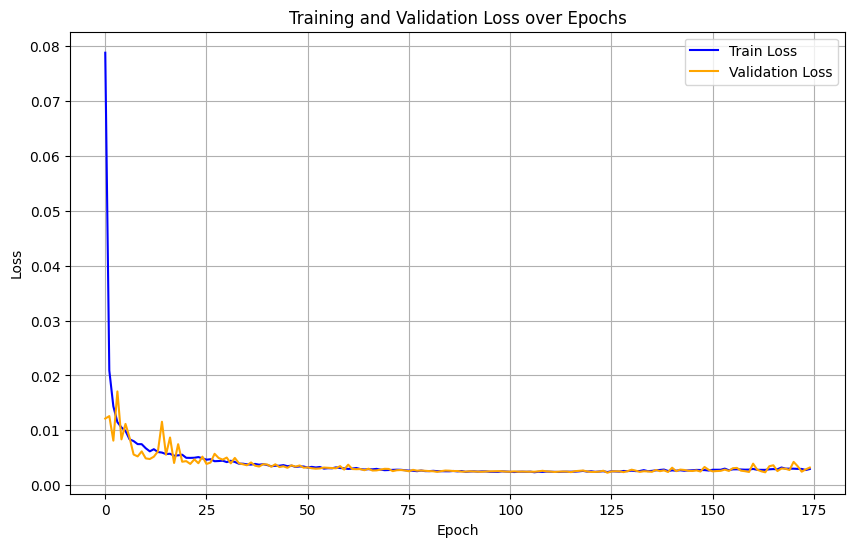

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [12]:
def check_and_clip_input(input_df, scaler):
    min_vals = scaler.data_min_
    max_vals = scaler.data_max_
    columns = scaler.feature_names_in_
    clipped = False
    for i, col in enumerate(columns):
        val = input_df.iloc[0, i]
        if val < min_vals[i] or val > max_vals[i]:
            print(f"Warning: '{col}' value {val} is out of range [{min_vals[i]}, {max_vals[i]}]. Clipping.")
            input_df.iloc[0, i] = min(max(val, min_vals[i]), max_vals[i])
            clipped = True
    if not clipped:
        print("All input values are within the training range.")
    return input_df

In [21]:
# Use a sample from the dataset for inference
# new_input = [[734, 0.1575, 25900, 20, 0.98] + [329.386266207629, 352.551499568358, 352.553759702364, 350.275738614983, 339.497145930202, 329.185115858301, 321.851178317625, 319.313289675805, 319.313289675805, 319.313289675805]]
# new_input = [[389, 0.1575, 25900, 20, 0.98]+[308.643914081496,329.496758659629,329.49784608407,327.585348377549,320.864532577509,315.25563745915,311.241414348336,309.692852226731,309.692852226731,309.692852226731]] 
new_input = [[12,0.1575,25900,3,0.98]+[313.940777400929,335.367531685418,335.367531685418,335.367531685418,335.367531685418,335.367531685418,335.367531685418,335.367531685418,335.367531685418,335.367531685418]]
theory_cols = [f"Theoretical_Temps_{i+1}" for i in range(10)]
input_columns = ["Time", "h", "flux", "abs", "surf"] + theory_cols
new_input_df = pd.DataFrame(new_input, columns=input_columns)
new_input_df = check_and_clip_input(new_input_df, X_scaler)  # Changed from new_input to new_input_df
new_input_scaled = X_scaler.transform(new_input_df)
new_tensor = torch.tensor(new_input_scaled, dtype=torch.float32).to(device)

model.eval()
with torch.no_grad():
    pred = model(new_tensor).cpu().numpy()
real_pred = y_scaler.inverse_transform(pred)
print("\nPredicted Temperatures:", real_pred.flatten().tolist())
# 355.85,356.13,357.28,358.06,357.61,359.74,357.45,358.39,368.22,358.85


Predicted Temperatures: [365.40679931640625, 361.61016845703125, 371.94940185546875, 372.04095458984375, 371.05517578125, 367.439697265625, 374.75653076171875, 371.82574462890625, 372.0, 376.5168762207031]


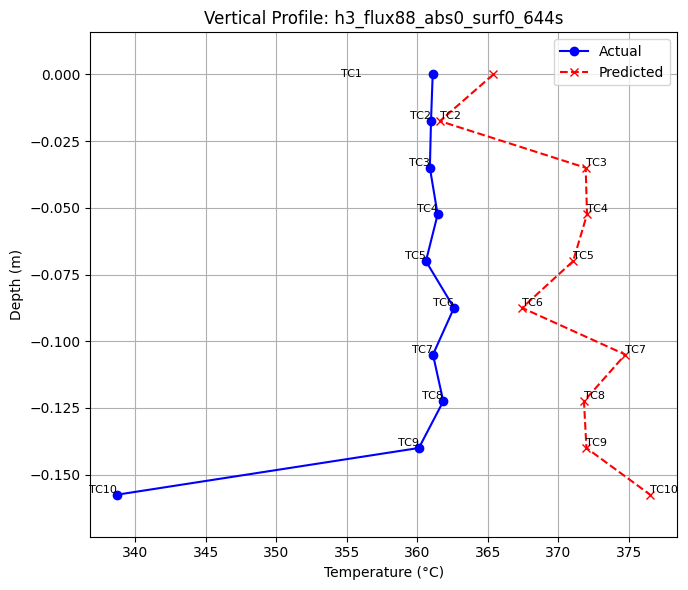

In [25]:
def plot_vertical_profile(predicted, actual, filename="Sample Profile"):
    sensor_labels = [f"TC{i+1}" for i in range(10)]
    total_height = 0.1575  # Total receiver height in meters
    spacing = total_height / 9  # 9 intervals between 10 sensors
    depths = [0 - i * spacing for i in range(10)]  # TC10 at 0, decreasing upwards
    
    plt.figure(figsize=(7, 6))
    plt.plot(actual, depths, label="Actual", color='blue', marker='o')
    plt.plot(predicted, depths, label="Predicted", color='red', marker='x', linestyle='--')
    plt.gca().invert_yaxis()  # Makes negative values go down
    
    # Add extra space (10%) at top and bottom
    y_margin = total_height * 0.10
    plt.ylim(-total_height - y_margin, 0 + y_margin)
    
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Depth (m)")
    plt.title(f"Vertical Profile: {filename}")
    plt.legend()

    # Add sensor labels (TC1 on left, others on right)
    for i, label in enumerate(sensor_labels):
        if i == 0:  # TC1 (top sensor) - place text on the left
            plt.text(min(actual[0], predicted[0]) - 5, depths[0], label, 
                     ha='right', va='center', fontsize=8, color='black')
        else:  # Other sensors - default right placement
            plt.text(actual[i], depths[i], label, ha='right', va='bottom', fontsize=8)
            plt.text(predicted[i], depths[i], label, ha='left', va='bottom', fontsize=8)

    plt.grid(True)
    plt.tight_layout()  # Prevent label cutoff
    plt.show()
    
# Use actual values from the dataset for comparison
# actual_values = [360.74, 360.08, 360.53, 360.79, 360.14, 361.79, 358.63, 359.26, 356.22, 335.77]
# actual_values = [359.64,358.86,359.41,359.51,359.17,361.24,358.75,359.21,356.32,336.55]
actual_values = [361.1,360.98,360.9,361.45,360.62,362.61,361.12,361.85,360.12,338.72]
# plot_vertical_profile(real_pred.flatten(), actual_values, filename="h6_flux88_abs20_wr_surf0_734s")
# plot_vertical_profile(real_pred.flatten(), actual_values, filename="h6_flux88_abs20_surf0_389s")
plot_vertical_profile(real_pred.flatten(), actual_values, filename="h3_flux88_abs0_surf0_644s")

In [ ]:
# Plot Predicted vs Actual Temperatures for 5 samples from the test set
num_samples = 30
for idx in range(num_samples):
    plt.figure(figsize=(8, 4))
    plt.plot(y_real[idx], label='Actual', marker='o')
    plt.plot(preds_real[idx], label='Predicted', marker='x')
    plt.title(f'Predicted vs Actual Temperatures (Sample {idx})')
    plt.xlabel('Sensor Index')
    plt.ylabel('Temperature (°C)')
    plt.legend()
    plt.grid(True)
    plt.show()

